# Tutorial: truss structures

### PREPROCESSING

Using bar elements (1 DOF), but in a 2D geometry. So set ndof_per_node = 2
Using elements_per_beam = 1, otherwise K will be singular (intermediate nodes float around since they do not have y and rotation constraints)

  __                _              _ _               
 / _|              | |            | | |              
| |_ ___ _ __ ___  | |_ ___   ___ | | |__   _____  __
|  _/ _ \ '_ ` _ \ | __/ _ \ / _ \| | '_ \ / _ \ \/ /
| ||  __/ | | | | || || (_) | (_) | | |_) | (_) >  < 
|_| \___|_| |_| |_| \__\___/ \___/|_|_.__/ \___/_/\_\
                ______                               
               |______|                              

github.com/Gabbbri/fem_toolbox


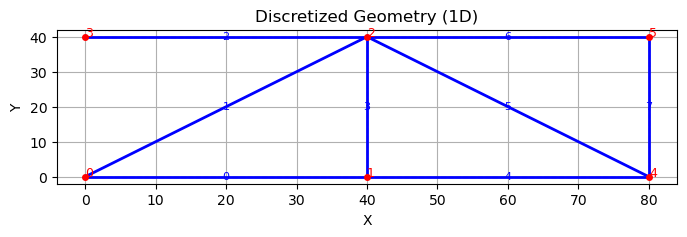

Constraint check passed: 4 DOFs constrained out of 12.


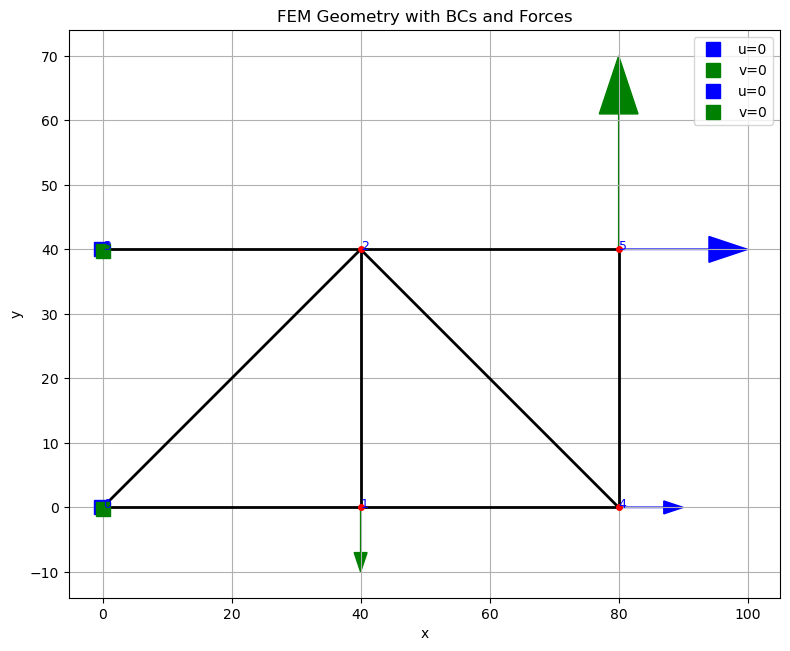

In [1]:
import fem_toolbox as ft

# read geometry

nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../geometry&boundary-files/trussTest.txt")

# meshing
elements_per_beam = 1   

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

# even if using truss elements (1 dof per node), we have a 2d structure, so in the global reference system there will be 2 dofs per node. The stiffness of the element will be only axial though
ndof_per_node = 2

# BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../geometry&boundary-files/trussTestBC.txt")

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndof_per_node, bc_nodes, bc_dofs)

# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.005)


## FEA ANALYSIS

Here call all the functions with ndof_per_node = 1, and remembering to give the reference to the rotation matrix. Only in this way the functions can understand that they are dealing with a truss 2D structure

In [2]:
# assemble global mass matrix rod
local_m_matrix = ft.elements.m_rod
local_k_matrix = ft.elements.k_rod
rotation_matrix = ft.elements.rotation_2d

ndof_per_node = 1   # truss element

K_global = ft.femsolver.assembleK(local_k_matrix, ft.elements.rotation_matrix_bar_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# uncomment if you have simpy installed (just for visualization)
#import sympy as sy
#display(sy.Matrix(K_global))

In [3]:
M_global = ft.femsolver.assembleM(local_m_matrix, ft.elements.rotation_matrix_bar_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)
#display(sy.Matrix(M_global))


Note in the function "build_force_vector" the extra parameters fiven here: struct2D_trussElements=True. This is necesssary since this particular function, not working with rotation matrices or boundary conditions, has no other mean to understand if we are dealing with truss structures

In [4]:
# assemble global force vector
num_dofs = K_global.shape[0]
print(num_dofs)
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node, struct2D_trussElements=True)

12


In [5]:
# solving for displacements
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(u)

[ 0.          0.          0.02133333  0.04083656 -0.016       0.04616989
  0.          0.          0.04266667  0.15009139 -0.00533333  0.16609139]


In [6]:
# solving for frequencies -> only 2 elements, so we expect only 2 modes
M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)
print(M_global.shape)

frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes=5, verbose=True)

(12, 12)
Mode 1: 5.34 Hz
Mode 2: 13.92 Hz
Mode 3: 19.65 Hz
Mode 4: 26.05 Hz
Mode 5: 52.39 Hz


## POST PROCESSING

Here we need again to switch to ndof_per_node = 2, as explained above

In [7]:
# post processing stresses
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, ft.elements.rotation_2d, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

print(stress_max)
print(stress_axial)
print(stress_bending)
print(stress_shear)

reactions, _ = ft.postprocessing.compute_reaction_forces(K_global, u, bc_nodes, bc_dofs, ndof_per_node)


[ 5333.33333333  3771.23616633 -4000.          1333.33333333
  5333.33333333 -5656.85424949  2666.66666667  4000.        ]
[ 5333.33333333  3771.23616633 -4000.          1333.33333333
  5333.33333333 -5656.85424949  2666.66666667  4000.        ]
[]
[]
DOF 0: Reaction force = -12000.00 N
DOF 1: Reaction force = -4000.00 N
DOF 6: Reaction force = 6000.00 N
DOF 7: Reaction force = 0.00 N


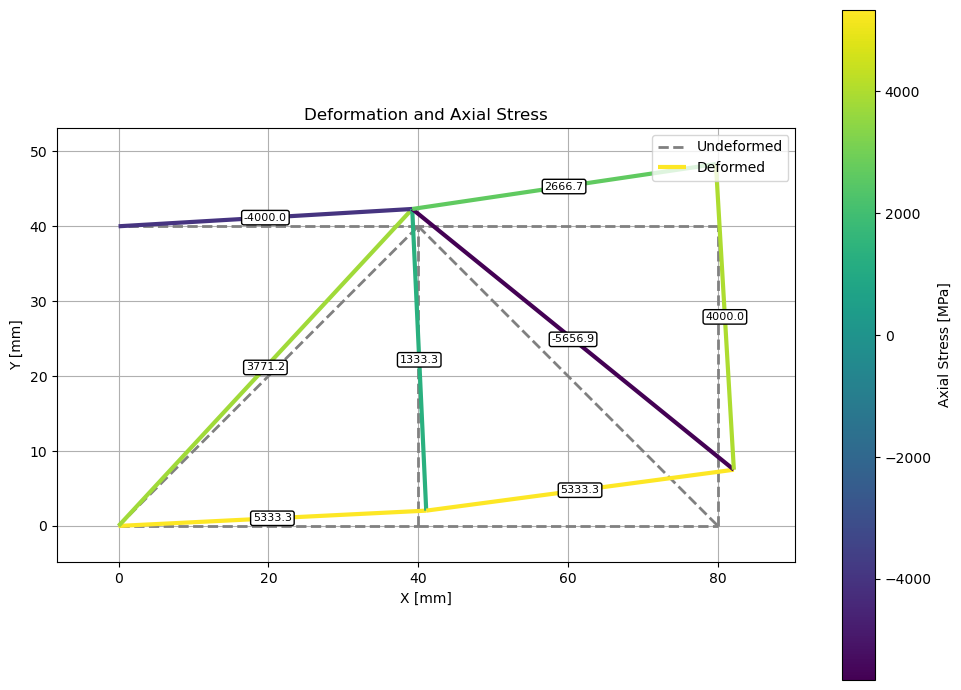

In [8]:
stress_type = "axial"
ft.postprocessing.plot_2D_loaded_structure(fem_nodes, fem_elements, u, stress_axial, stress_type, ndof_per_node=2, scale=50, show_labels=True)

In [9]:
# no internal actions plot, since using trusses we have only axial forces in the elements
#ft.postprocessing.plot_internal_actions_2D(beam_connectivity, fem_nodes, fem_elements, internal_actions, elements_per_beam=1)

In [10]:
ft.postprocessing.animate_mode_shape_2D(mode_index=0, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=2, amplification=10)

## OPTIMIZATION

Trying out the optimization routines for truss structures (for the prototype and the "tutorial", see the subdirectory ./shape_optimization)

### Stress-constrained optimization

In [11]:
sigma_max = 100

optim_areas = ft.optimizer.optimize_crossSections4stress_trusses(element_crossSections, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, ft.elements.rotation_matrix_bar_2d, A_min=0.01)

print(optim_areas)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 21599.999999948894
            Iterations: 12
            Function evaluations: 111
            Gradient evaluations: 12
[80.         56.56854249 60.         20.         80.         84.85281374
 40.         60.        ]


In [12]:
ft.optimizer.checkOptimization_stresses_trusses(element_crossSections, optim_areas, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_ext, f_nodes, f_dofs, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, ft.elements.rotation_matrix_bar_2d)

Element  | Area (orig) | Area (opt) | Stress (orig) | Stress (opt) | max_stress
---------|-------------|------------|----------------|----------------|----------
   0     |    1.50     |   80.00    |    5333.33     |     100.00     |    100.00
   1     |    1.50     |   56.57    |    3771.24     |     100.00     |    100.00
   2     |    1.50     |   60.00    |    -4000.00    |    -100.00     |    100.00
   3     |    1.50     |   20.00    |    1333.33     |     100.00     |    100.00
   4     |    1.50     |   80.00    |    5333.33     |     100.00     |    100.00
   5     |    1.50     |   84.85    |    -5656.85    |    -100.00     |    100.00
   6     |    1.50     |   40.00    |    2666.67     |     100.00     |    100.00
   7     |    1.50     |   60.00    |    4000.00     |     100.00     |    100.00


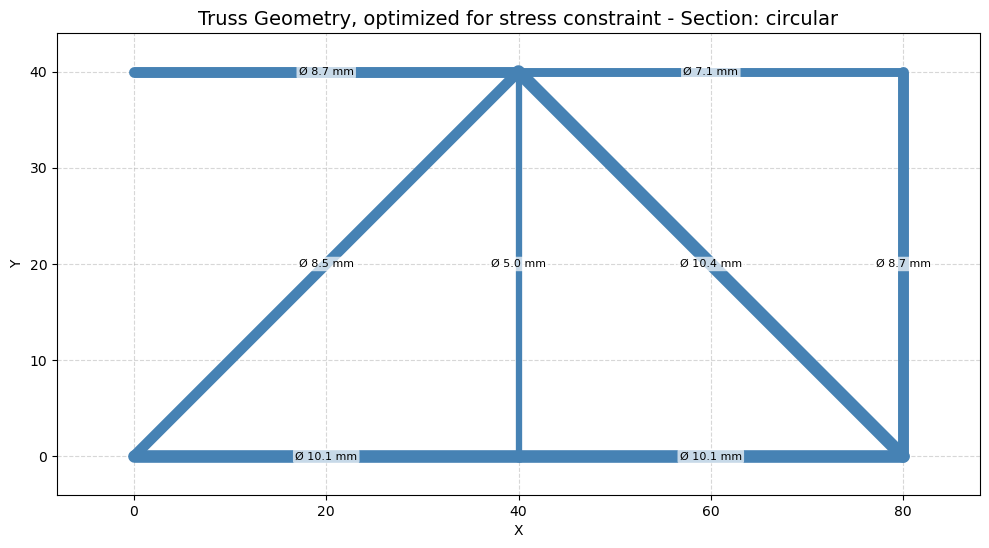

In [13]:
ft.optimizer.optim_plot_truss_geometry(
    fem_nodes=fem_nodes,
    fem_elements=fem_elements,
    areas=optim_areas,
    section_shape="circular",    # or "rectangle"
    color="steelblue",
    scale_factor=0.9,
    show_labels=True
)

**NOTE**
For a truss structure, the tuning of the penalization hyperparameters is not simple. Instead of manually changing, trying and re running the function, it is better to use the method shown below, present in the fem_toolbox.optimizer sub-module. 

!!! Can happen that the optimizer finds a solution, but the cross sections of the elements jump a lot from the min to the max bounds. In that case, it is recommended to run again the function. The optimizer should be able, with a bit of luck, to find also better solutions where the cross sectional areas of the trusses have not so much variance

In [17]:
forbidden_range = (5, 14)

best_result, best_hparams = ft.optimizer.optimizeFrequency_random_hyperparameter_search(
    max_trials=30,
    element_crossSections=element_crossSections,
    forbidden_range=forbidden_range,
    fem_nodes=fem_nodes,
    fem_elements=fem_elements,
    mat_properties=mat_properties,
    ndof_per_node=ndof_per_node,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    bc_values=bc_values,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    num_modes=5,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    rotation_func=ft.elements.rotation_matrix_bar_2d,
    A_min=40,
    A_max=240
)



[Trial 1] Trying with:
  Uniformity penalty: 0.2253
  Smoothness penalty: 0.1154
  Boundary penalty:   106.50
[40.         42.92591862 40.         40.         43.33535012 42.16002345
 42.99782787 40.        ]
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 646.7202106407933
            Iterations: 61
            Function evaluations: 743
            Gradient evaluations: 57

	              Optimization was not successfull. Please try again

❌ Trial 1 failed: Positive directional derivative for linesearch

[Trial 2] Trying with:
  Uniformity penalty: 0.3450
  Smoothness penalty: 0.1658
  Boundary penalty:   313.22
[40.         40.         48.35465076 46.41131166 41.44035294 40.
 42.12891696 40.        ]
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1595.9345201934138
            Iterations: 53
            Function evaluations: 622
            Gradient evaluations: 49

	            

In [18]:
print(best_result)

[130.00271405  40.          41.69487721 153.48611137 152.21642852
 130.45641688  40.4568355   41.68187083]


In [19]:
optim_areas_freq = best_result
print(optim_areas_freq)

ft.optimizer.checkOptimization_frequencies_trusses(element_crossSections, optim_areas_freq, forbidden_range, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, ft.femsolver.assembleK, ft.femsolver.assembleM, local_k_matrix, local_m_matrix, ft.elements.rotation_matrix_bar_2d)

[130.00271405  40.          41.69487721 153.48611137 152.21642852
 130.45641688  40.4568355   41.68187083]

Element-wise Area Comparison:
Element | Area (original) | Area (optimized)
--------|------------------|------------------
   0     |       1.50       |      130.00     
   1     |       1.50       |      40.00      
   2     |       1.50       |      41.69      
   3     |       1.50       |      153.49     
   4     |       1.50       |      152.22     
   5     |       1.50       |      130.46     
   6     |       1.50       |      40.46      
   7     |       1.50       |      41.68      

Forbidden frequency band
    f_min = 5
    f_max = 14


Modal Frequencies Comparison:
Mode    | Frequency (orig) | Frequency (opt)
--------|------------------|-----------------
   1     |      5.3374      |     3.8642     
   2     |     13.9235      |     14.2925    
   3     |     19.6516      |     17.1406    
   4     |     26.0471      |     29.1161    
   5     |     52.3950      |   

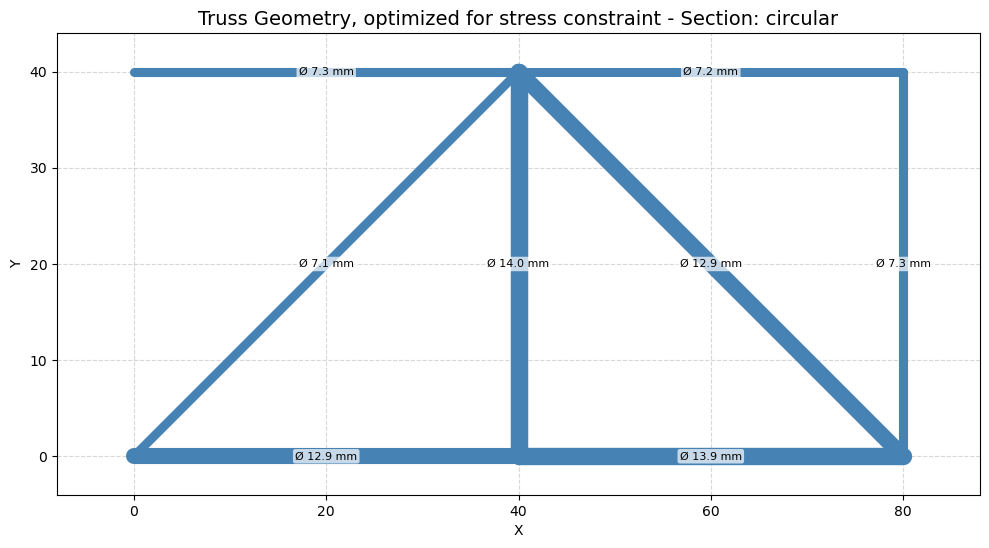

In [20]:
ft.optimizer.optim_plot_truss_geometry(
    fem_nodes=fem_nodes,
    fem_elements=fem_elements,
    areas=optim_areas_freq,
    optim="frequencies"
    section_shape="circular",    # or "rectangle"
    color="steelblue",
    scale_factor=0.9,
    show_labels=True
)